This notebook contains scripts to instantiate and run the entraining plume model. The code has been tested on ARM site observations from Nauru and CACTI. <br>
The user can specify the ARM site, custom preprocessing script, launch level, and choose between simple microphysics schemes.<br>
This script also contains example analyses of the plume model output. <br>

<b> Note: </b>If you change the input data, you will likely have to specify your own preprocessor to hand off temperature, humidity, level and time information to the plume model wrapper (see PlumeModel class in PlumeModel.py).



In [1]:
import importlib
import PlumeModel
from preprocessors import preprocess_ARMBE, preprocess_Nauru
importlib.reload(PlumeModel)
import time
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
# Preprocess interpolated sondes

In [81]:
input_dir = Path('/neelin2020/ARM/CACTI/')
fil_interpsonde = [str(i) for i in (input_dir/'interpsonde').glob('*.nc')]
fil_interpsonde.sort()


In [62]:
import xarray as xr
def preprocess_interpsonde_CACTI(fils):
    ds = xr.open_mfdataset(fils)
    temp = ds.temp.dropna(dim = 'time', how = 'all')  # drop times with all NaNs
    ds = ds.sel(time = temp.time)
    return ds.temp.values + 273, ds.sh.values, ds.bar_pres.values * 1e1, ds.time.values


### ARMBE

In [79]:
site = 'CACTI'
output_dir = './'  # directory to save the output files

if site == 'Nauru':

    output_file_name = 'plume_props_Nauru'  # name of the output file
    input_dir = '/neelin2020/ARM/ARM_Nauru/'
    fils = [str(i) for i in Path(input_dir).glob('ARM_NAURU_Tq*.nc')]  # look for all .nc files in the directory
    preprocess = preprocess_Nauru

elif site == 'CACTI':

    output_file_name = 'plume_props_CACTI'  # name of the output file
    input_dir = '/neelin2020/ARM/CACTI/'
    fils = [str(i) for i in Path(input_dir).glob('corarmbeatm*.nc')]  # look for all .nc files in the directory
    preprocess = preprocess_ARMBE


kwargs = dict(fils = fil_interpsonde, 
        preprocess = preprocess_interpsonde_CACTI,
        output_file_name = output_file_name, 
        output_dir = output_dir, 
        launch_opt = 'specified',  # specified level or from the surface
        launch_level = 880,        # launch level in hPa
        rain_out = 1e2,            # rain out threshold (kg/kg)
        conserved = 1,            # 1: theta_il, 2: theta_e
        DIB_mix_upper = 450,       # upper level for DIB mixing; no mixing above this level
        microphysics = 2, 
        mix_opt = 'NOMIX',         # mixing option: 'DIB' or 'NOMIX'
        C0 = 0.2, 
        qsat_opt = 1)


# run plume model
RUN = False
if RUN:
    pm = PlumeModel.PlumeModel(**kwargs)
    pm.preprocess_data()
    pm.mixing_coefficients()

    stime = time.time()
    pm.run_plume(mix = pm.mix_opt)
    print(f'Done. Took {time.time()-stime: .3f} seconds')
    pm.postprocess_save()

### Interpolated Sonde

In [94]:
fil_interpsonde

['/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20180928.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20180929.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20180930.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181001.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181002.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181003.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181004.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181005.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181006.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181007.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181008.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181009.000030.nc',
 '/n

In [80]:
# keywords for the PlumeModel
kwargs = dict(fils = '', 
              preprocess = preprocess_interpsonde_CACTI,
              output_file_name = '', 
              output_dir = './interpsonde_CACTI/', 
              launch_opt = 'specified',  # specified level or from the surface
              launch_level = 880,        # launch level in hPa
              rain_out = 1e2,            # rain out threshold (kg/kg)
              conserved = 1,            # 1: theta_il, 2: theta_e
              DIB_mix_upper = 450,       # upper level for DIB mixing; no mixing above this level
              microphysics = 2, 
              mix_opt = 'NOMIX',         # mixing option: 'DIB' or 'NOMIX'
              C0 = 0.2, 
              qsat_opt = 1)

for fil in fil_interpsonde:
    file_name = 'plume_model.'+(Path(fil).stem)
    kwargs.update(output_file_name = file_name, fils = fil)
    pm = PlumeModel.PlumeModel(**kwargs)
    pm.preprocess_data()
    pm.mixing_coefficients()

    stime = time.time()
    pm.run_plume(mix = pm.mix_opt)
    print(f'Done. Took {time.time()-stime: .3f} seconds')
    pm.postprocess_save()

    break


RUNNING NOMIX PLUME COMPUTATION
Done. Took  0.010 seconds
SAVING FILE
File saved as interpsonde_CACTI/plume_model.corinterpolatedsondeM1.c1.20180928.nc


## Analyze saved output

In [82]:
import xarray as xr
fil_out = pm.output_file_name.with_suffix('.nc')
ds = xr.open_dataset(fil_out)

### Plot buoyancy time series and example $\theta_e$ of the plume and environment

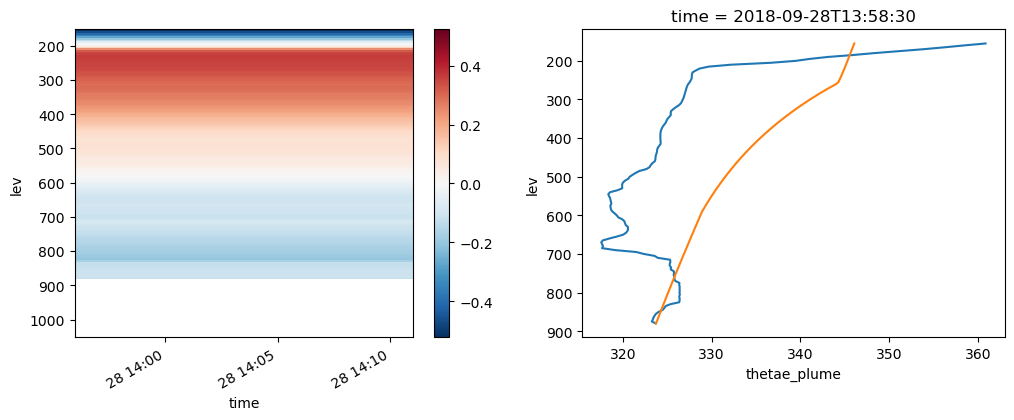

In [84]:
fig, axx = plt.subplots(1, 2, figsize = (12, 4))
buoy = 9.8 * (ds.Tv_plume - ds.Tv_env)/ds.Tv_env
buoy.plot(y = 'lev', yincrease = False, ax = axx[0])

tidx = 2
ds.thetae_env.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = axx[1])
ds.thetae_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = axx[1])


In [85]:
# Layer averaged buoyancy and precipitation
from scipy.io import loadmat
fil_nauru = '/neelin2020/ARM/ARM_Nauru/precip_nauru_1hravg_matchedtosondes_Apr2001_Aug2006.mat'

def compute_layer_ave_buoy(ds, pstrt = 800, pend = 400):
    """
    Use the virtual temperature to compute 
    layer-averaged buoyancy
    """
    g = 9.8
    buoy = g * (ds.Tv_plume - ds.Tv_env)/ds.Tv_env
    buoy_slice = buoy.sel(lev = slice(pstrt, pend)).dropna('lev')
    layer_depth = buoy_slice.lev.isel(lev = 0) - buoy_slice.lev.isel(lev = -1) 
    return -buoy_slice.integrate('lev')/(layer_depth)
 

def open_files_include_precip(ds, fils, site):
    buoy_lft = compute_layer_ave_buoy(ds)

    if site == 'CACTI':
        ds_prc = xr.open_mfdataset(fils)
        ds_prc = ds_prc.where(ds_prc.time.isin(buoy_lft.time), drop = True)
        prc = ds_prc.precip_rate_sfc
        prc = prc.where(prc.time.isin(buoy_lft.time), drop = True)
        ds['precip'] = prc

    elif site == 'NAURU':
        data = loadmat(fil_nauru)
        precip = data['precmeancholloworig']
        ds['precip'] = (('time'), precip.squeeze())

    return ds, buoy_lft

# compute LFT buoy
ds, buoy_lft = open_files_include_precip(ds, fils, site)

## Precipitation-buoyancy statistics 

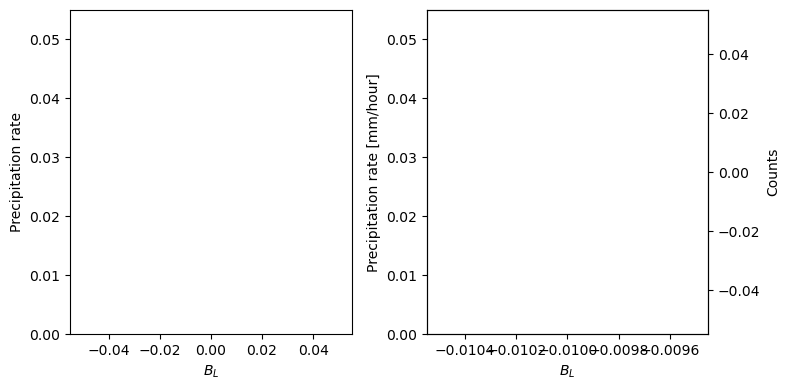

In [86]:
import numpy as np
buoy_bins = np.arange(-0.3, 0.0, 0.04)
buoy_bins = np.append(buoy_bins, (np.arange(0, 0.25, 0.05)))

fig, axx = plt.subplots(1, 2, figsize = (8, 4))
ax = axx[0]
ax.scatter(buoy_lft, ds.precip)

ax.set_ylim(bottom = 0)
ax.set_ylabel('Precipitation rate')
ax.set_xlabel('$B_L$')

ax = axx[1]
ax2 = ax.twinx()
ds.precip.groupby_bins(buoy_lft, bins = buoy_bins).count().plot(ax = ax2)
ds.precip.groupby_bins(buoy_lft, bins = buoy_bins).mean().plot(ax = ax, c = 'black', marker = '*')

ax.set_ylim(bottom = 0)
ax2.set_ylabel('Counts')
ax.set_xlabel('$B_L$')
plt.tight_layout()


## Example hydrometeor information<br>
Note: if the freezing level is below the LCL, the plume liquid water may not contain any liquid water

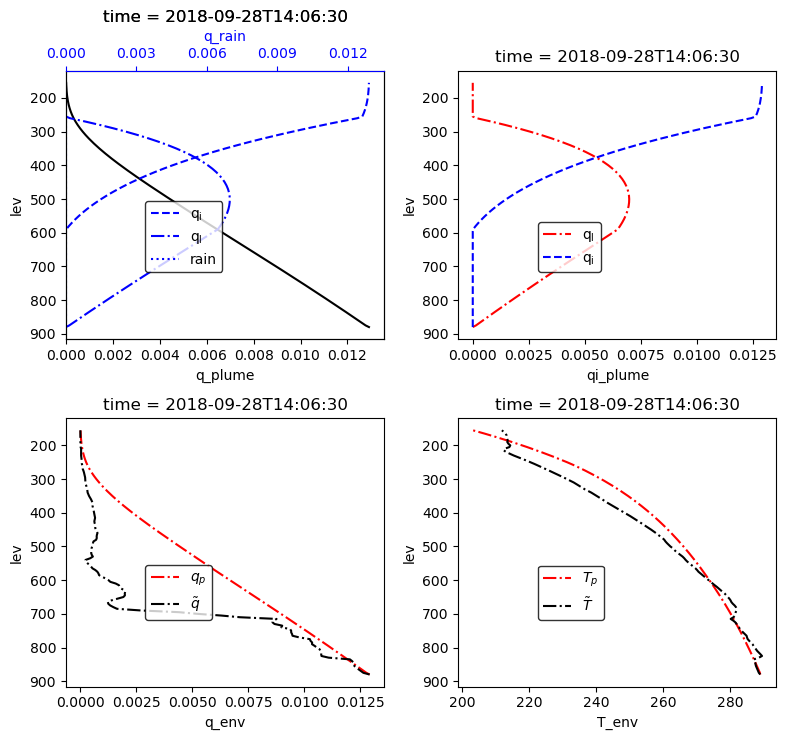

In [91]:
g = 9.8 
fig, axx = plt.subplots(2, 2, figsize = (8, 7.5))
tidx = 10

ax = axx[0,0]
ax2 = ax.twiny()
ds.q_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, color = 'black')
ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
ds.ql_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = '-.', label = '$\mathrm{q_l}$')
ds.q_rain.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = ':', label = 'rain')

ax2.spines['top'].set_color('blue') 
ax2.xaxis.label.set_color('blue')
ax2.tick_params(axis='x', colors='blue')
ax.set_xlim(left = 0)
ax2.set_xlim(left = 0)
leg = ax2.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')
# set major locator
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

ax = axx[0,1]
ds.ql_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'red', linestyle = '-.', label = '$\mathrm{q_l}$')
ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
leg = ax.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')

ax = axx[1,0]
ds.q_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'red', linestyle = '-.', label = '$q_p$')
ds.q_env.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'black', linestyle = '-.', label = '$\\tilde{q}$')

# ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
leg = ax.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')

ax = axx[1,1]
ds.T_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'red', linestyle = '-.', label = '$T_p$')
ds.T_env.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'black', linestyle = '-.', label = '$\\tilde{T}$')

# ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
leg = ax.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')

# ds.q_rain.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = ':', label = 'rain')


plt.tight_layout()

In [96]:
ds.time

<xarray.DataArray 'time' (time: 15)>
array(['2018-09-28T13:56:30.000000000', '2018-09-28T13:57:30.000000000',
       '2018-09-28T13:58:30.000000000', '2018-09-28T13:59:30.000000000',
       '2018-09-28T14:00:30.000000000', '2018-09-28T14:01:30.000000000',
       '2018-09-28T14:02:30.000000000', '2018-09-28T14:03:30.000000000',
       '2018-09-28T14:04:30.000000000', '2018-09-28T14:05:30.000000000',
       '2018-09-28T14:06:30.000000000', '2018-09-28T14:07:30.000000000',
       '2018-09-28T14:08:30.000000000', '2018-09-28T14:09:30.000000000',
       '2018-09-28T14:10:30.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-09-28T13:56:30 ... 2018-09-28T14:10:30
Attributes:
    long_name:      Time offset from midnight
    axis:           T
    bounds:         time_bounds
    standard_name:  time

Thermal or Archimedean Buoyancy: $ B = g \frac{T_{vp} - \bar{T}_v}{\bar{T}_v}$<br>
$B_L = \frac{1}{\Delta p_L}\int^{500}_{800} B dp$<br>
$T_v = T(1 + \epsilon q_v - q_c)$ <br>
$\theta_e = f(T,q,p)$

### Plume buoyancy conditionally averaged by $\mathrm{B_L}$

/tmp/ipykernel_4144633/1662975625.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(ScalarMappable(cmap = cm, norm = norm),


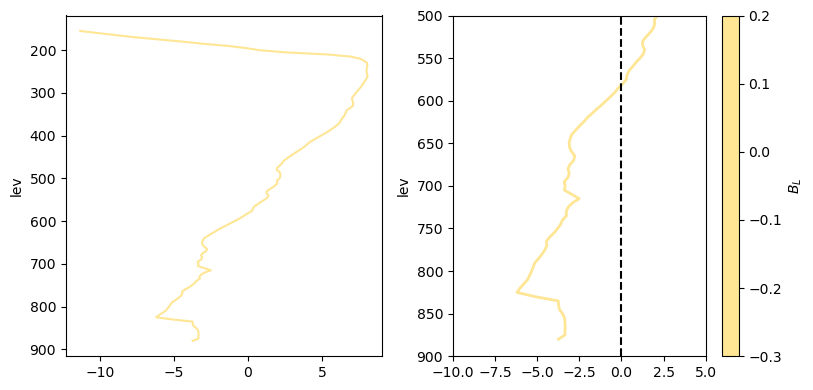

In [92]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib import ticker

fig, axx = plt.subplots(1, 2, figsize = (8, 4))

ax = axx[0]
DeltaTv = (ds.Tv_plume - ds.Tv_env).groupby_bins(buoy_lft, bins = buoy_bins)
cmap = plt.colormaps['Spectral_r']
norm = Normalize(vmin = buoy_bins[0], vmax = buoy_bins[-1])
cm_list = []
for i, (key, group) in enumerate(DeltaTv):
    group.mean('time').plot(y = 'lev', yincrease = False, 
                            ax = ax, label = key, color = cmap(norm(key.mid)))
    
    group.mean('time').plot(y = 'lev', yincrease = False, 
                            ax = axx[1], label = key, linewidth = 2.,
                            color = cmap(norm(key.mid)))
    cm_list.append(cmap(norm(key.mid)))
    
    cm_list.append(cmap(norm(key.mid)))

cm = LinearSegmentedColormap.from_list('defcol', cm_list)

axx[1].set_ylim(900,500)
axx[1].set_xlim(-10, 5)
axx[1].vlines(0, 900, 500, linestyle = '--', color = 'black')
plt.tight_layout()

cb = plt.colorbar(ScalarMappable(cmap = cm, norm = norm), 
             ticks = buoy_bins[::4], label='$B_L$')
cb.ax.yaxis.set_major_locator(ticker.AutoLocator())


### EOF analysis on buoyancy profiles

/tmp/ipykernel_4144633/2669956079.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ax.plot(vec[:, 0], buoy_anom.lev, label = f'EOF 1 ({eig[0]*100/eig.sum():.2f}%)' )
/tmp/ipykernel_4144633/2669956079.py:9: RuntimeWarning: invalid value encountered in double_scalars
  ax.plot(vec[:, 1], buoy_anom.lev, label = f'EOF 2 ({eig[1]*100/eig.sum():.2f}%)')


(-1.0, 10.0)

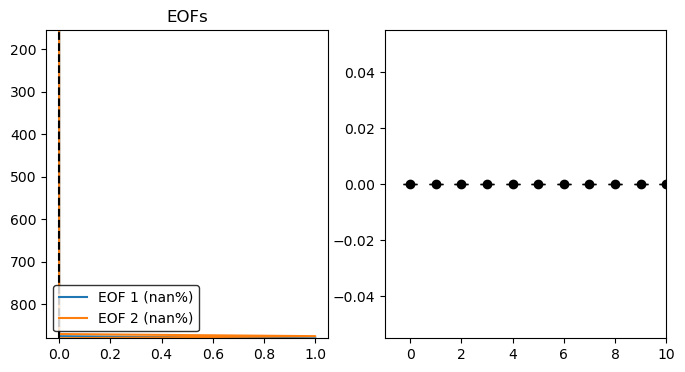

In [93]:
import numpy as np
# buoy_anom = (buoy - buoy.mean('time')).dropna('lev')
buoy_anom = (buoy - buoy.mean('time')).dropna('lev', how = 'all').dropna('time')
eig, vec = np.linalg.eig(np.cov(buoy_anom.T))

fig, axx = plt.subplots(1, 2, figsize = (8, 4))
ax = axx[0]
ax.plot(vec[:, 0], buoy_anom.lev, label = f'EOF 1 ({eig[0]*100/eig.sum():.2f}%)' )
ax.plot(vec[:, 1], buoy_anom.lev, label = f'EOF 2 ({eig[1]*100/eig.sum():.2f}%)')

ax.set_ylim(buoy_anom.lev[0], buoy_anom.lev[-1])
ax.set_title('EOFs', fontsize = 12)
leg = ax.legend(loc = 'lower left')
leg.get_frame().set_edgecolor('black')
ax.vlines(0, buoy_anom.lev[0], buoy_anom.lev[-1], linestyle = '--', color = 'black')

ax = axx[1]
N = buoy_anom.time.size
# ax.scatter(range(eig.size), eig)
ax.errorbar(range(eig.size), eig, yerr = 1.96 * eig * np.sqrt(2/N), fmt = 'o', capsize=5,
color = 'black')
ax.set_xlim(-1,10)
